# image denoising in wavelet domain

Date: 23/10/2020

Name: You ZUO, Jingzhuo HUI

In [1]:
from nt_toolbox.general import *
from nt_toolbox.signal import *
import numpy as np
import scipy
%load_ext autoreload
%autoreload 2
%pylab inline

import matplotlib.pyplot as plt
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


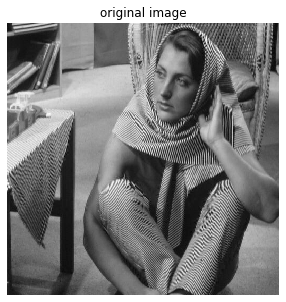

In [2]:
# input our dataset image Barbara
img = load_image('barbara.jpg')

plt.figure(figsize=(5,5));plt.axis('off');plt.title('original image')
plt.imshow(img,cmap = 'gray')
plt.show()

## Simulate a noisy version of the image using the noises at various SNR Level (0 db, 10 dB and 20 dB)

In [3]:
def GenerateNoise(signal, SNR_dB): # desiredSNR [dB]; signal is an array with complex values
   shape = signal.shape
   snr = 10.0**(SNR_dB/10.0) # Desired linear SNR
   var_signal = np.sum(signal**2)/(shape[0]*shape[1]) # Measure power of signal
   # SNR = var_signal / var_n
   sigma = np.sqrt(var_signal / snr) # Calculate required noise power for desired SNR
   # print(sigma) # to calculate sigma used later
   noise = np.random.randn(shape[0],shape[1]) * sigma # Generate noise with calculated power
   return noise

def NoisyImage(signal, SNR_dB):
    noise_img = np.copy(signal)
    e = GenerateNoise(noise_img, SNR_dB)
    noise_img = noise_img + e
    # print(np.log10(np.sum(signal**2)/np.sum((noise_img-signal)**2))*10)
    return noise_img

In [4]:
SNRs = [0,10,20]
titles = ['snr = 0','snr = 10','snr = 20']
cache_ = []

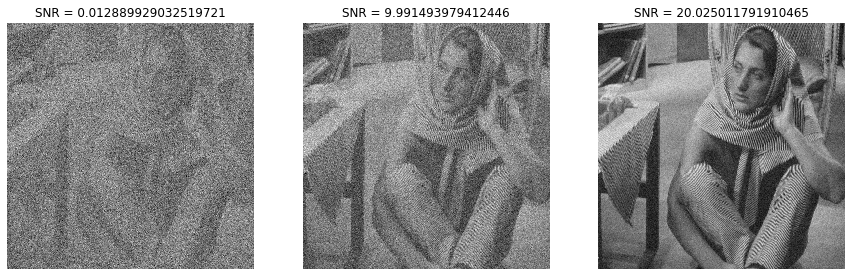

In [5]:
fig, axs = plt.subplots(nrows = 1, ncols = len(SNRs), figsize = (15, 15))
for ind, snr in enumerate(SNRs):
    res = NoisyImage(img, snr)
    cache_.append(res)

    ax = axs[ind]
    ax.title.set_text('SNR = ' + str(np.log10(np.sum(img**2)/np.sum((res-img)**2))*10))
    ax.imshow(res, cmap='gray')
    ax.axis('off')
plt.show()

## Denoise the image by performing hard thresholding and soft thresholding in the wavelet domain
### Hard Thresholding in Wavelet Bases

In [6]:
def thresh_hard(u,t):return u*(abs(u)>t)
# Parameters for the orthogonal wavelet transform of filter daubechies.
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/norm(h)
Jmin = 2

In [7]:
# values calculated before when generating noisy images (sigma = np.sqrt(variance_signal / snr))
sigmas = [0.48356658756788634, 0.15291718170697832, 0.04835665875678863]

In [8]:
def hard_wavelet_trans(signal,sigma,h,Jmin):
    # compute the wavelet coefficients a of the noisy image signal.
    a = perform_wavortho_transf(signal,Jmin,+1,h)
    # Select the threshold value, that should be proportional to the noise level σ.
    T = 3*sigma
    # Hard threshold the coefficients below the noise level to obtain aT(m)=s0T(am).
    aT = thresh_hard(a,T)

    fHard = perform_wavortho_transf(aT,Jmin,-1,h)
    #Display the denoising result.
    imageplot(clamp(fHard), 'Hard, SNR=' + str(np.log10(np.sum(img**2)/np.sum((fHard-img)**2))*10))

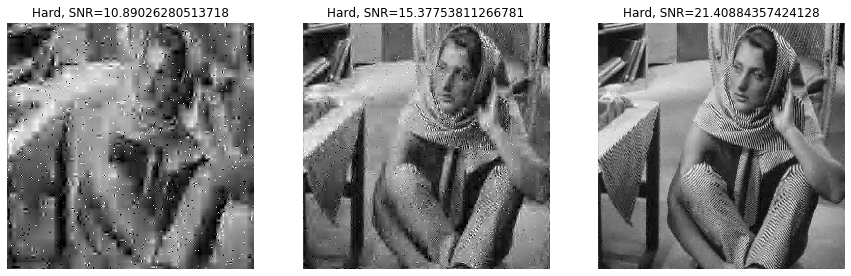

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = len(sigmas), figsize = (15, 15))
for i in range(len(sigmas)):
    plt.subplot(1,3,i+1)
    hard_wavelet_trans(cache_[i],sigmas[i],h,Jmin)
    ax.axis('off')
plt.show()

From the results above we can see that: after implementing a hard thresholding wavelet denoising, the SNRs have been improved a lot, especially for those who had very low SNR before.

### Wavelet Denoising with Soft Thesholding

In [12]:
def thresh_soft(u,t):return maximum(1-t/abs(u), 0)*u

def soft_wavelet_trans(signal,sigma,h,Jmin):
    # compute the wavelet coefficients a of the noisy image signal.
    a = perform_wavortho_transf(signal,Jmin,+1,h)
    # Select the threshold.
    T = 3/2*sigma
    # Perform the soft thresholding.
    aT = thresh_soft(a,T)
    # To slightly improve the soft thresholding performance, we do not threshold the coefficients corresponding to coarse scale wavelets.
    aT[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]

    # Reconstruct the soft thresholding estimator f̃.
    fSoft = perform_wavortho_transf(aT,Jmin,-1,h)
    # Display the soft thresholding denoising result.
    imageplot(clamp(fSoft), 'Soft, SNR=' + str(np.log10(np.sum(img**2)/np.sum((fSoft-img)**2))*10) )

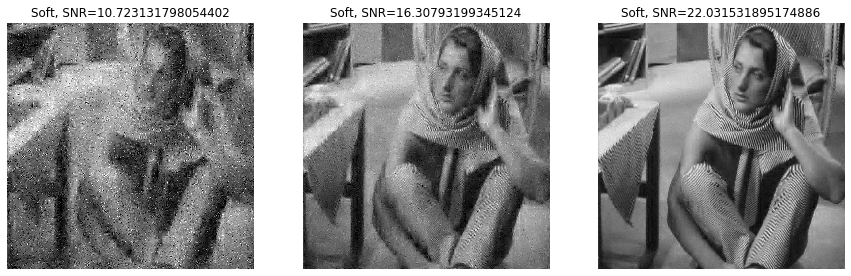

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = len(sigmas), figsize = (15, 15))
for i in range(len(sigmas)):
    plt.subplot(1,3,i+1)
    soft_wavelet_trans(cache_[i],sigmas[i],h,Jmin)
    ax.axis('off')
plt.show()

Here we can see that with the soft theresholding method, noisy images with higher level of SNR before have better results after denoising (for noisy images with SNR = 10, 20), while it performed relatively worse for noisy image with very low level SNR.

### Discuss the parameters (wavelet type, number of level, type of thresholding)

#### wavelet type:
What we implemented befoore is a Wavelet Daubechies 2 (db2) low-pass filter, dbN wavelets have very nice properties like orthogonality, and easy to smooth. For N = 1 it is the Haar wavelet. Biorthogonal wavelets are wavelets that are symmetric, not orthogonal, biorthogonal. While Wavelet Coiflets are near symmetric, orthogonal, biorthogonal.
#### sigma:
the noise level
#### T:
the threshold for denoising, which is proportional to the noise level $\sigma$. It is designed to filter the waves that are relatively trivial with low wavelet coefficients. Usually we set T = 3 * sigma, so that we can convince ourselves that there is 99.73% probability that we filtered the noise.
#### type of thresholding:
We have two kinds of thresholding, the hard thresholding and soft thresholding. The soft thresholding is also called wavelet shrinkage, as values for both positive and negative coefficients are being "shrinked" towards zero, in contrary to hard thresholding which either keeps or removes values of coefficients.

### Denoise the image by implementing translation invariant wavelet transform

In [14]:
def invar_wavelet_trans(signal,sigma,m=4):
    n = signal.shape[0]
    # Generate a set of shifts (δi)i.
    [dY,dX] = meshgrid(arange(0,m),arange(0,m))
    delta = concatenate( (dX.reshape(m*m,1), dY.reshape(m*m,1)), axis=1)

    fTI = zeros([n,n])
    T = 3*sigma
    for i in arange(0,m*m):
        fS = circshift(signal,delta[i,:])
        a = perform_wavortho_transf(fS,Jmin,1,h)
        aT = thresh_hard(a,T)
        fS = perform_wavortho_transf(aT,Jmin,-1,h)
        fS = circshift(fS,-delta[i,:])
        fTI = i/(i+1.0)*fTI + 1.0/(i+1)*fS
    imageplot(clamp(fTI), 'TI, SNR=' + str(np.log10(np.sum(img**2)/np.sum((fTI-img)**2))*10)  )

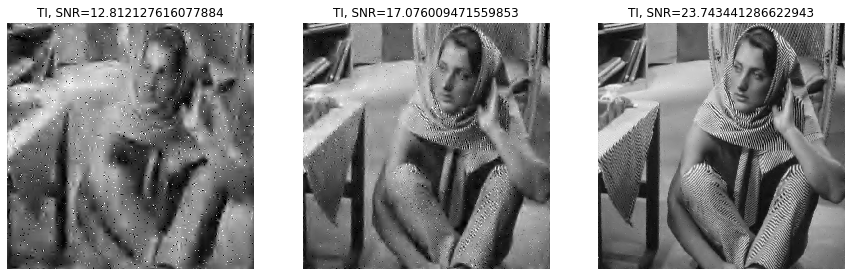

In [15]:
fig, axs = plt.subplots(nrows = 1, ncols = len(sigmas), figsize = (15, 15))
for i in range(len(sigmas)):
    plt.subplot(1,3,i+1)
    invar_wavelet_trans(cache_[i],sigmas[i],10)
    ax.axis('off')
plt.show()